In [1]:
%matplotlib notebook

In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
import seaborn as sns

import networkx as nx

import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
from mpl_toolkits import mplot3d

In [3]:
plt.rcParams.update({'figure.max_open_warning': 0})

# Aggregate data

In [4]:
# Define folder containing the processed data
base_input_path = "D:\\_OUTPUT\\_RUNS\\RUN3_CP4.0.3\\siNuMa\\Analysis_Output\\Movies\\"
input_files = glob.glob(os.path.join(base_input_path,"**/*.csv"),recursive=True)
print("nb. of files:",len(input_files))

nb. of files: 38


In [5]:
# Define conditions
conditions = ["SICTRL","SINUMA"]
# conditions = ["SICTRL","SITNKS","SINUMA","SITNKS-SINUMA"]

In [6]:
# Aggregating...

# Create "Aggregation" subfolder
base_input_spath = os.path.join(base_input_path,"Aggregation")
if not os.path.exists(base_input_spath):
    os.makedirs(base_input_spath)
    
# Create "Tables" subfolder
base_input_spath_table = os.path.join(base_input_path,"Aggregation","Tables")
if not os.path.exists(base_input_spath_table):
    os.makedirs(base_input_spath_table)
    
# Create "Figures" subfolder
base_input_spath_fig = os.path.join(base_input_path,"Aggregation","Figures")
if not os.path.exists(base_input_spath_fig):
    os.makedirs(base_input_spath_fig)

# Limit directories to be checked
sub_path = "ANALYSED_CSV"
sub_path2 = "PROCESSED_CSV"

trackinfo = []
movie_col, cond_col, date_col, clone_col = [], [], [], []
df = pd.DataFrame() # empty df

for f in input_files:
    sf = f.split(base_input_path)[1].upper() # exclude base path and make all to upper case
    if sub_path2 in sf: # if the file is in processed_csv dir
        dftmp = pd.read_csv(f)
        if len(dftmp)>0:
            
            info = np.load(os.path.join(f.split("Processed_CSV")[0],"trackinfo.npy"),allow_pickle=True).item()

            # tracks excluded by border violation
            trackinfo += [(info["Movie"],item,"border_violated") for item in np.setdiff1d(info["total_tracks"],info["tracks_border_filtered"])]
            
            # tracks excluded by border transistion violation
            trackinfo += [(info["Movie"],item,"transistion_violated") for item in np.setdiff1d(info["tracks_border_filtered"],info["tracks_transistion_filtered"])]

            # tracks excluded by time alignment convention
            trackinfo += [(info["Movie"],item,"alignment_violated") for item in np.setdiff1d(info["tracks_transistion_filtered"],info["tracks_time_aligned"])]
            
            # tracks remain
            trackinfo += [(info["Movie"],item,"passed") for item in info["tracks_time_aligned"]]
    
    elif sub_path in sf: # if the file is in analysed_csv dir
        condlst = []
        for c in conditions: # check conditions
            if c in sf:
                condlst.append(c)
        if len(condlst)>0: # if the file is in a condition
            # assign best fit condition
            imax = np.argmax([len(c) for c in condlst])
            condlbl = condlst[imax]
        
            match_day = re.search(r'\d{8}', sf) # searching date pattern
            match_clone = re.search(r"_CL(.+)_",os.path.basename(sf)) # searching clone pattern
            if (match_clone is None): # if failed, try another template for clone pattern
                match_clone = re.search(r"_CL(.+)\.",os.path.basename(sf))
            if (match_day is not None) & (match_clone is not None): # find it!
                datelbl = "d"+match_day.group()
                clonelbl = "cl"+match_clone.group(1)
                moviename = os.path.basename(sf).split(".CSV")[0]
                dftmp = pd.read_csv(f)
                if len(dftmp)>0:
                    movie_col += [moviename for _ in range(len(dftmp))]
                    cond_col += [condlbl for _ in range(len(dftmp))]
                    date_col += [datelbl for _ in range(len(dftmp))]
                    clone_col += [clonelbl for _ in range(len(dftmp))]
                    df = df.append(dftmp) 
                    
dftrackinfo = pd.DataFrame(trackinfo,columns=["Movie","TrackObjects_Label","Status"])
                    
df["Movie"] = movie_col
df["Condition"] = cond_col
df["Date"] = date_col
df["Clone"] = clone_col
df["Index"] = range(len(df))
df.set_index("Index",inplace=True)

## Tracks info table

This table indicate status of track: **passed** or **excluded** (violation of border, transistion rule or alignment rule)

In [7]:
dftrackinfo

,Movie,TrackObjects_Label,Status
0,siCTRL_20190422_Pos02_cl7,5.0,border_violated
1,siCTRL_20190422_Pos02_cl7,6.0,border_violated
2,siCTRL_20190422_Pos02_cl7,7.0,border_violated
3,siCTRL_20190422_Pos02_cl7,11.0,border_violated
4,siCTRL_20190422_Pos02_cl7,12.0,border_violated
...,...,...,...
686,siNuMa_20190524_Pos10_cl16,29.0,passed
687,siNuMa_20190524_Pos10_cl16,32.0,passed
688,siNuMa_20190524_Pos10_cl16,37.0,passed
689,siNuMa_20190524_Pos10_cl16,39.0,passed


In [8]:
print("total tracks:",len(dftrackinfo))
print("tracks excluded by border:",len(dftrackinfo[dftrackinfo["Status"]=="border_violated"]))
print("tracks excluded by transistion:",len(dftrackinfo[dftrackinfo["Status"]=="transistion_violated"]))
print("tracks excluded by time alignment:",len(dftrackinfo[dftrackinfo["Status"]=="alignment_violated"]))
print("tracks remain:",len(dftrackinfo[dftrackinfo["Status"]=="passed"]))

total tracks: 691
tracks excluded by border: 386
tracks excluded by transistion: 0
tracks excluded by time alignment: 160
tracks remain: 145


In [9]:
# Save to file
filename = os.path.join(base_input_spath_table,"tracks_info.csv")
dftrackinfo.to_csv(filename,index=False)

## Aligned tracks table

This table show tracks after time points alignment (only for **passed** tracks).

In [10]:
df.head(10) # display top 10 rows

,Nucleus_State_Number,Reference_Time,ImageNumber,ObjectNumber,TrackObjects_Label,AreaShape_Area,AreaShape_Perimeter,Intensity_IntegratedIntensity_H2B_Smooth,Intensity_IntegratedIntensity_TRF1_Smooth,Intensity_MeanIntensity_H2B_Smooth,...,Mean_Telomere_AreaShape_Perimeter,Mean_Telomere_Distance_Minimum_Nuclei,Mean_Telomere_Distance_Centroid_Nuclei,Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth,Children_Telomere_Count,Nucleus_State_Name,Movie,Condition,Date,Clone
Index,,,,,,,,,,,,,,,,,,,,,
0,1.0,-1.9,1.0,1.0,1.0,11787.0,424.132034,244.493316,71.035769,0.020743,...,16.755910,23.209214,36.596142,0.428068,65.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
1,1.0,-1.8,2.0,1.0,1.0,12088.0,429.303607,245.676067,72.422421,0.020324,...,17.211760,21.519704,39.543903,0.435536,67.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
2,1.0,-1.7,3.0,1.0,1.0,11841.0,426.374675,244.899515,69.959297,0.020682,...,16.787226,22.085806,37.812418,0.432585,65.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
3,1.0,-1.6,4.0,1.0,1.0,11766.0,423.546248,243.548031,70.119292,0.020699,...,16.799066,20.797336,39.178148,0.444261,64.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
4,1.0,-1.5,5.0,1.0,1.0,11085.0,407.605122,230.762884,60.074537,0.020818,...,15.277204,21.784382,36.456143,0.351383,68.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
5,1.0,-1.4,6.0,2.0,1.0,10777.0,413.605122,226.157670,62.844402,0.020985,...,16.686067,21.087757,36.998162,0.422691,62.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
6,1.0,-1.3,7.0,2.0,1.0,10784.0,399.060967,222.501133,61.048326,0.020633,...,16.703095,21.416579,36.579053,0.394206,64.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
7,1.0,-1.2,8.0,2.0,1.0,10736.0,406.333044,221.658724,66.929612,0.020646,...,15.652404,21.273671,36.591199,0.378934,73.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7
8,1.0,-1.1,9.0,2.0,1.0,10894.0,408.090404,223.781450,62.840531,0.020542,...,15.056812,21.813256,36.299026,0.327774,71.0,interphase,SICTRL_20190422_POS02_CL7,SICTRL,d20190422,cl7


In [11]:
print("List of features can be used in plots:")
[print(col) for col in df.columns];

List of features can be used in plots:
Nucleus_State_Number
Reference_Time
ImageNumber
ObjectNumber
TrackObjects_Label
AreaShape_Area
AreaShape_Perimeter
Intensity_IntegratedIntensity_H2B_Smooth
Intensity_IntegratedIntensity_TRF1_Smooth
Intensity_MeanIntensity_H2B_Smooth
Intensity_MeanIntensity_TRF1_Smooth
Mean_Telomere_AreaShape_Area
Mean_Telomere_AreaShape_Perimeter
Mean_Telomere_Distance_Minimum_Nuclei
Mean_Telomere_Distance_Centroid_Nuclei
Mean_Telomere_Intensity_IntegratedIntensity_TRF1_Smooth
Children_Telomere_Count
Nucleus_State_Name
Movie
Condition
Date
Clone


In [56]:
 df["AreaShape_Circularity"] = df["AreaShape_Perimeter"] / (2* np.sqrt(np.pi*df["AreaShape_Area"]))

In [57]:
# save to file
filename = os.path.join(base_input_spath_table,"aligned_tracks.csv")
df.to_csv(filename,index=False)

## States table

This table specifies state name and its ID.

In [58]:
state_df = df[["Nucleus_State_Number","Nucleus_State_Name"]].drop_duplicates().set_index("Nucleus_State_Number")["Nucleus_State_Name"]
state_df.sort_index(inplace=True)
print(state_df)

Nucleus_State_Number
1.0      interphase
2.0        prophase
3.0    prometaphase
4.0       metaphase
5.0        anaphase
Name: Nucleus_State_Name, dtype: object


In [59]:
# save to file
filename = os.path.join(base_input_spath_table,"states.csv")
state_df.reset_index().to_csv(filename,index=False)

## Transistion probability table

This table provides probability for each transistion.

In [60]:
# build pb graph
G=nx.DiGraph()
G.add_nodes_from(state_df.values);
for name in state_df.values:
    G.add_edge(name,name,label=[])
for i in range(len(state_df)-1):
    for j in range(1,len(state_df)):
        G.add_edge(state_df.iloc[i],state_df.iloc[j],label=[])
        G.add_edge(state_df.iloc[j],state_df.iloc[i],label=[])

# retrieve npy files storing state transistion matrices
npy_files = glob.glob(os.path.join(base_input_path,"**/*.npy"),recursive=True)
print("nb. of files:",len(npy_files))

# count transistion cases
valid_files = []
for f in npy_files:
    matching = re.search(r"1border",os.path.basename(f)) 
    if matching is not None:
        valid_files.append(f)
        M = np.load(f)
        for ir in range(M.shape[0]):
            r = M[ir]
            
            total_cases = len(r[r!=0])
            if total_cases > 0:
                G2=nx.DiGraph()
                G2.add_nodes_from(state_df.values);
                for name in state_df.values:
                    G2.add_edge(name,name,label=0.)
                for i in range(len(state_df)-1):
                    for j in range(1,len(state_df)):
                        G2.add_edge(state_df.iloc[i],state_df.iloc[j],label=0.)
                        G2.add_edge(state_df.iloc[j],state_df.iloc[i],label=0.)

                for i in range(len(r)-1):
                    if((r[i]!=0) & (r[i+1]!=0)):
                        G2.edges[state_df[r[i]],state_df[r[i+1]]]["label"] += 1.

                for key, val in G2.edges.items():
                    G.edges[key[0],key[1]]["label"].append(G2.edges[key[0],key[1]]["label"]/total_cases)
                    
# build pb dataframe
edge_dic = nx.get_edge_attributes(G,"label")
pbdf = pd.Series(index=list(edge_dic.keys()), data=[np.mean(val) for val in edge_dic.values()], name='Probability')
pbdf = np.round(pbdf*100,2)  
pbdf.index.name = "Group"
print("transistion probability (%)")
print(pbdf)

nb. of files: 68
transistion probability (%)
Group
(interphase, interphase)        67.13
(interphase, prophase)           1.22
(interphase, prometaphase)       0.81
(interphase, metaphase)          0.13
(interphase, anaphase)           0.08
(prophase, prophase)             0.95
(prophase, interphase)           1.16
(prophase, prometaphase)         0.34
(prophase, metaphase)            0.00
(prophase, anaphase)             0.00
(prometaphase, prometaphase)     1.78
(prometaphase, interphase)       0.51
(prometaphase, prophase)         0.02
(prometaphase, metaphase)        0.82
(prometaphase, anaphase)         0.31
(metaphase, metaphase)           1.37
(metaphase, interphase)          0.27
(metaphase, prophase)            0.00
(metaphase, prometaphase)        0.16
(metaphase, anaphase)            0.33
(anaphase, anaphase)             1.15
(anaphase, interphase)           0.84
(anaphase, prophase)             0.00
(anaphase, prometaphase)         0.19
(anaphase, metaphase)            0.07

In [16]:
# save to file
filename = os.path.join(base_input_spath_table,"transistion_probability.csv")
pbdf.reset_index().to_csv(filename,index=False)

# Number of tracked objects by Reference time

Check how many objects were tracked upto a given ref time.

<IPython.core.display.Javascript object>


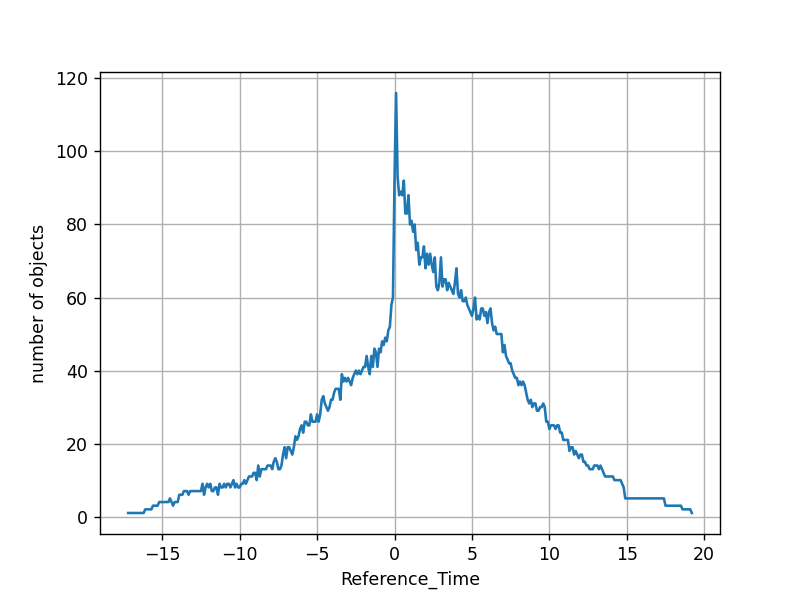

In [61]:
# group by reference times and count number of cases
gr = df.groupby("Reference_Time").count()["Nucleus_State_Number"]
fig = plt.figure()
ax = fig.add_subplot(111)
gr.plot(ax=ax)
ax.set_ylabel("number of objects");
ax.grid();

**Comments**: there're not many objects can be tracked beyond +-15 hours.

In [18]:
# save fig
filename = os.path.join(base_input_spath_fig,"Number_Tracked_Objects_by_RefTime.png")
fig.savefig(filename,dpi=300)

## Clip dataframe within ref time interval

Observing the above plot, we can limit the data into a ref time interval. Here I chose [-10,10] since the number of tracked objects > 15 which might be good for stats ?

In [62]:
sdf = df.copy()

# Define reference time interval
thr1, thr2 = 8,-4
sdf = sdf[(sdf["Reference_Time"]<=thr1)&(sdf["Reference_Time"]>=thr2)]

print("nb. of tracks after clip:",np.sum([len(item) for item in sdf.groupby(["Movie"])["TrackObjects_Label"].unique().values]))

nb. of tracks after clip: 145


# Filter tracks

We may want to filter tracks based on some criteria.

## Max telomere count in interphase

In [63]:
# Define max telomere count for interphase
max_telomere_count = 10

# list of tracks having max children telomere < 20 for interphase
filter_df = sdf[sdf["Nucleus_State_Name"]=="interphase"]
df_count = filter_df.groupby(["Movie","TrackObjects_Label"])["Children_Telomere_Count"].max()
indices = list(df_count[df_count<max_telomere_count].index)
print("nb of tracks being excluded",len(indices))
indices

nb of tracks being excluded 40


[('SICTRL_20190422_POS02_CL7', 2.0),
 ('SICTRL_20190422_POS03_CL7', 43.0),
 ('SICTRL_20190422_POS04_CL7', 4.0),
 ('SICTRL_20190422_POS04_CL7', 21.0),
 ('SICTRL_20190422_POS04_CL7', 25.0),
 ('SICTRL_20190524_POS02_CL16', 5.0),
 ('SICTRL_20190524_POS02_CL16', 16.0),
 ('SICTRL_20190524_POS03_CL16', 9.0),
 ('SICTRL_20190524_POS03_CL16', 21.0),
 ('SINUMA_20190422_POS06_CL7', 42.0),
 ('SINUMA_20190422_POS07_CL7', 51.0),
 ('SINUMA_20190422_POS08_CL7', 13.0),
 ('SINUMA_20190422_POS09_CL7', 4.0),
 ('SINUMA_20190422_POS09_CL7', 41.0),
 ('SINUMA_20190422_POS09_CL7', 54.0),
 ('SINUMA_20190422_POS10_CL7', 15.0),
 ('SINUMA_20190524_POS08_CL16', 11.0),
 ('SINUMA_20190524_POS09_CL16', 10.0),
 ('SINUMA_20190524_POS09_CL16', 35.0),
 ('SINUMA_20190524_POS10_CL16', 3.0),
 ('SINUMA_20190524_POS10_CL16', 4.0),
 ('SINUMA_20190524_POS10_CL16', 5.0),
 ('SINUMA_20190524_POS10_CL16', 6.0),
 ('SINUMA_20190524_POS10_CL16', 7.0),
 ('SINUMA_20190524_POS10_CL16', 8.0),
 ('SINUMA_20190524_POS10_CL16', 11.0),
 ('SINUMA

In [64]:
# remove tracks
for movie,label in indices:
    removing_ix = sdf[((sdf["Movie"]==movie)&(sdf["TrackObjects_Label"]==label))].index
    sdf = sdf.drop(removing_ix)

# Tracks summary

Show some summaries per track e.g. track duration, mitotic duration, etc.

In [65]:
print("nb. of tracks after filtering:",np.sum([len(item) for item in sdf.groupby(["Movie"])["TrackObjects_Label"].unique().values]))

nb. of tracks after filtering: 105


## Mitotic duration

In [66]:
# Define mitotic states
mitotic = ["prophase","prometaphase","metaphase","anaphase"]

super_data = []
for ix, gr in sdf.groupby(["Movie","TrackObjects_Label"]):
    track_duration = (len(gr)-1)*0.1
    mitotic_duration = (len(gr[gr["Nucleus_State_Name"].isin(mitotic)])-1)*0.1
    if mitotic_duration < 0:
        mitotic_duration = 0
    super_data.append((ix[0],ix[1],
                       track_duration,mitotic_duration,
                       gr["Condition"].values[0],gr["Date"].values[0],gr["Clone"].values[0]))
    
superdf = pd.DataFrame(super_data,columns=["Movie","TrackObjects_Label",
                                           "Track_Duration","Mitotic_Duration",
                                           "Condition","Date","Clone"])
superdf.set_index(["Movie","TrackObjects_Label"],inplace=True)

In [67]:
superdf

Track_Duration  \
Movie                      TrackObjects_Label                   
SICTRL_20190422_POS02_CL7  1.0                            9.7   
                           8.0                            7.9   
SICTRL_20190422_POS03_CL7  2.0                           11.6   
                           5.0                            5.9   
                           11.0                           8.7   
...                                                       ...   
SINUMA_20190524_POS09_CL16 20.0                           1.8   
                           22.0                           4.4   
                           26.0                           0.8   
SINUMA_20190524_POS10_CL16 16.0                           0.1   
                           39.0                           0.3   

                                               Mitotic_Duration Condition  \
Movie                      TrackObjects_Label                               
SICTRL_20190422_POS02_CL7  1.0                              0.9    SICTRL   
                           8.0                              0.1    SICTRL   
SICTRL_20190422_POS03_CL7  2.0                              0.6    SICTRL   
                           5.0                              1.3    SICTRL   
                           11.0                             0.7    SICTRL   
...                                                         ...       ...   
SINUMA_20190524_POS09_CL16 20.0                             0.1    SINUMA   
                           22.0                             0.6    SINUMA   
                           26.0                             0.0    SINUMA   
SINUMA_20190524_POS10_CL16 16.0                             0.1    SINUMA   
                           39.0                             0.3    SINUMA   

                                                    Date Clone  
Movie                      TrackObjects_Label                   
SICTRL_20190422_POS02_CL7  1.0                 d20190422   cl7  
                           8.0                 d20190422   cl7  
SICTRL_20190422_POS03_CL7  2.0                 d20190422   cl7  
                           5.0                 d20190422   cl7  
                           11.0                d20190422   cl7  
...                                                  ...   ...  
SINUMA_20190524_POS09_CL16 20.0                d20190524  cl16  
                           22.0                d20190524  cl16  
                           26.0                d20190524  cl16  
SINUMA_20190524_POS10_CL16 16.0                d20190524  cl16  
                           39.0                d20190524  cl16  

[105 rows x 5 columns]

In [68]:
# save to file
filename = os.path.join(base_input_spath_table,"Mitosis_Length.csv")
superdf.reset_index().to_csv(filename,index=False)

### SAVE SUPERDF

<IPython.core.display.Javascript object>


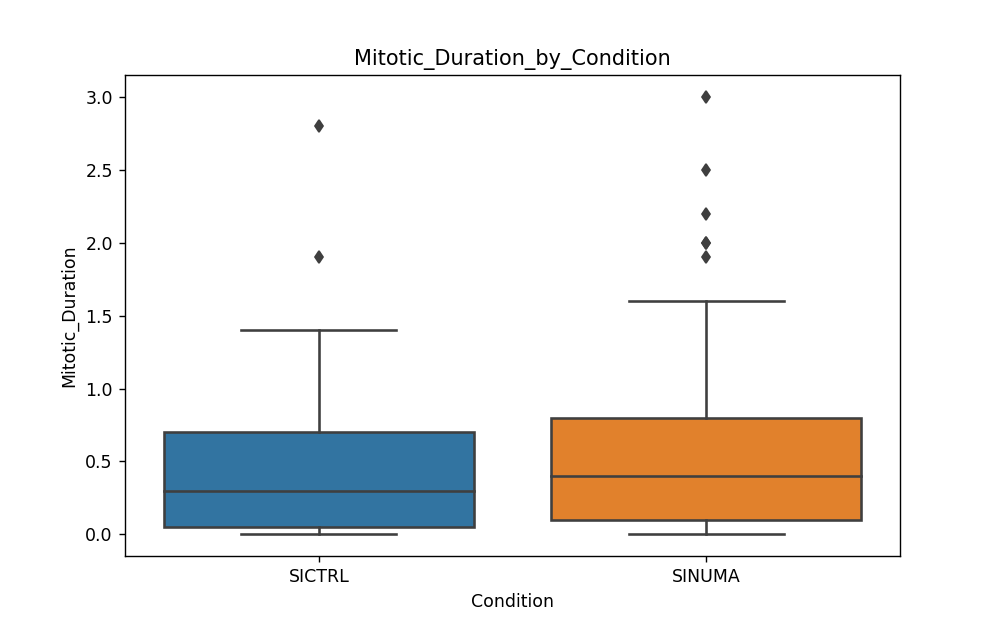

In [25]:
# boxplot
xvar = "Condition"
yvar = "Mitotic_Duration"
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.boxplot(x=xvar, y=yvar, data=superdf);
ax.set_title(yvar+"_by_"+xvar);

## Track duration

<IPython.core.display.Javascript object>


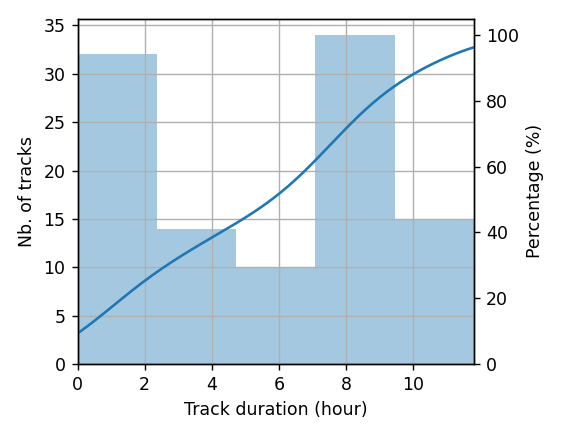

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


In [26]:
fig = plt.figure(figsize=(4.5,3.5))
ax = fig.add_subplot(111)
sns.distplot(superdf["Track_Duration"].values,kde=False,norm_hist=False)
ax.grid();
ax.set_xlabel("Track duration (hour)");
ax.set_ylabel("Nb. of tracks");

ax2=ax.twinx()
kwargs = {'cumulative': True}
sns.kdeplot(superdf["Track_Duration"].values,cumulative=True)
ax2.set_ylabel("Percentage (%)");
ax2.set_yticklabels((ax2.get_yticks()*100.).astype(np.int));
ax2.set_xlim(superdf["Track_Duration"].min(),superdf["Track_Duration"].max());
ax2.set_xticks(np.arange(superdf["Track_Duration"].min(),superdf["Track_Duration"].max()+1,2));
plt.tight_layout();

# Heatmap

## State transisions

In [51]:
feature = "Nucleus_State_Number"
# feature_min, feature_max = sdf[feature].min(), sdf[feature].max()
feature_min, feature_max = int(sdf[feature].min()), int(sdf[feature].max())

<IPython.core.display.Javascript object>


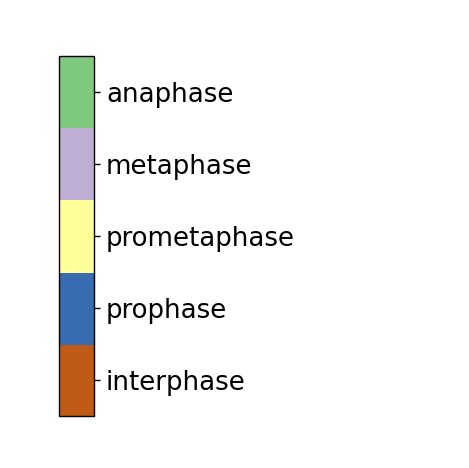

In [52]:
# custom colorbar
basecmap = cm.get_cmap("Accent_r",feature_max+1)
mycmap = ListedColormap(basecmap(np.arange(feature_min,feature_max+1)/(feature_max)))


fig, ax = plt.subplots(figsize=(3, 3))
fig.subplots_adjust(right=0.2)

norm = mpl.colors.Normalize(vmin=feature_min-0.5, vmax=feature_max+0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mycmap, 
                                norm=norm, orientation='vertical')

cb1.set_ticks(np.arange(feature_min,feature_max+1))
ax.set_yticklabels([state_df[i] for i in np.arange(feature_min,feature_max+1)],fontsize=15,color="k");
# cb1.set_label("state",fontsize=15,color="k");

<IPython.core.display.Javascript object>


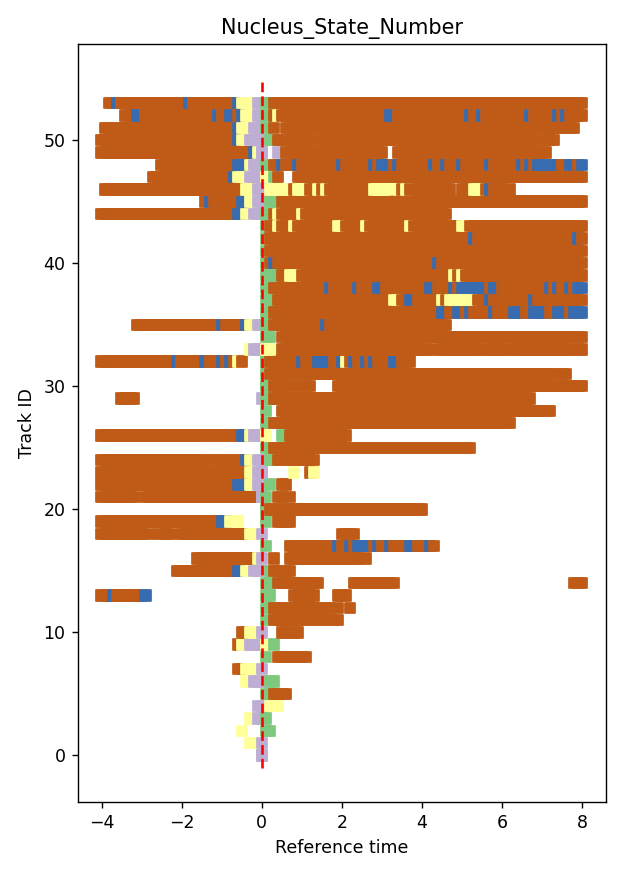

In [53]:
# Define condition
cond = "SINUMA"
ssdf = sdf[sdf["Condition"]==cond]

ssdflen = ssdf.groupby(["Movie","TrackObjects_Label"])["Reference_Time"].count()*0.1
sort_ix = ssdflen.sort_values(ascending=True).index

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)

item = 0
track_ids = []
for six in sort_ix:
    movie, track = six[0], six[1]
    tmp = ssdf[(ssdf["Movie"]==movie)&(ssdf["TrackObjects_Label"]==track)]
    ax.scatter(tmp["Reference_Time"],[item for _ in range(len(tmp))],
               c=tmp[feature],marker="s",cmap=mycmap,vmin=feature_min,vmax=feature_max)
    item += 1
    track_ids.append((movie,track))
        
ax.vlines(0,-1,item+1,color="r",linestyle="dashed")

ax.set_xlabel("Reference time")
ax.set_ylabel("Track ID");
# ax.invert_yaxis();
ax.set_title(feature);
plt.tight_layout();

In [54]:
# save fig
filename = os.path.join(base_input_spath_fig,"Heatmap_States_{}.png".format(cond))
fig.savefig(filename,dpi=300)

### check outliers tracks

In [55]:
# get track information - useful to check outliers
# ID = 28
# print(track_ids[ids_to_check])
print([track_ids[ix] for ix in [28,8]])

[('SINUMA_20190524_POS06_CL16', 31.0), ('SINUMA_20190524_POS09_CL16', 26.0)]


## Other features

In [38]:
# Define feature
feature = "Children_Telomere_Count"
feature_min = sdf[feature].min()
feature_max = np.percentile(sdf[feature],95) # clip the display values <= 95th percentile for clear viz
print(feature_min,feature_max)

1.0 67.0


<IPython.core.display.Javascript object>


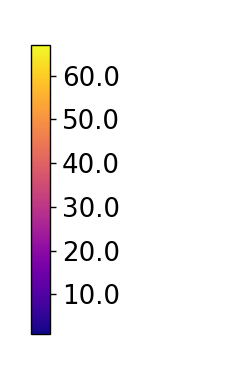

C:\Users\debbi\Anaconda3\envs\LiveAnalysis\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


In [39]:
# custom colorbar
mycmap = cm.get_cmap("plasma") # choose colormap 

fig, ax = plt.subplots(figsize=(2, 3))
fig.subplots_adjust(right=0.2)

norm = mpl.colors.Normalize(vmin=feature_min, vmax=feature_max)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mycmap, norm=norm, orientation='vertical')

ax.set_yticklabels(np.round(cb1.get_ticks(),2),fontsize=15,color="k");
# cb1.set_label("averaged branchings",fontsize=15,color="k");

<IPython.core.display.Javascript object>


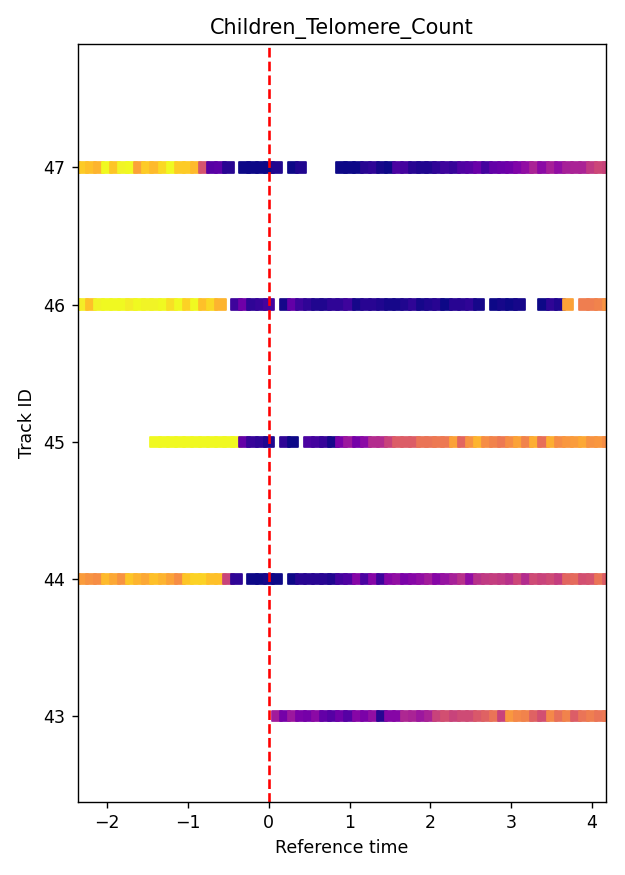

In [42]:
# Define condition
cond = "SINUMA"
ssdf = sdf[sdf["Condition"]==cond]

ssdflen = ssdf.groupby(["Movie","TrackObjects_Label"])["Reference_Time"].count()*0.1
sort_ix = ssdflen.sort_values(ascending=True).index

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111)

item = 0
track_ids = []
for six in sort_ix:
    movie, track = six[0], six[1]
    tmp = ssdf[(ssdf["Movie"]==movie)&(ssdf["TrackObjects_Label"]==track)]
    ax.scatter(tmp["Reference_Time"],[item for _ in range(len(tmp))],
               c=tmp[feature],marker="s",cmap=mycmap,vmin=feature_min,vmax=feature_max)
    item += 1
    track_ids.append((movie,track))
        
ax.vlines(0,-1,item+1,color="r",linestyle="dashed")

# ax.grid("on");
ax.set_xlabel("Reference time")
ax.set_ylabel("Track ID")
ax.set_title(feature);
plt.tight_layout();

In [43]:
# save fig
filename = os.path.join(base_input_spath_fig,"Heatmap_{}_{}.png".format(feature,cond))
fig.savefig(filename,dpi=300)

In [46]:
# get track information
print([track_ids[ix] for ix in [28,31,46]])

[('SINUMA_20190524_POS06_CL16', 31.0), ('SINUMA_20190422_POS07_CL7', 17.0), ('SINUMA_20190422_POS08_CL7', 18.0)]


### Batch processing

# Plots by reference time

This section studies how feature change w.r.t. reference time.

Set "yvar" by a feature we would like to plot. You can set "huevar" by "Condition", "Date", or "Clone".

In [ ]:
# Define feature
yvar = "Children_Telomere_Count"

xvar = "Reference_Time"

# Define group: can be Condition, Date, Clone
huevar = "Condition" 

**Note**: Set "ci=68" equals to "SE" in case of normal distribution assumption (large sample size).

Link: 
- https://academic.csuohio.edu/kneuendorf/c53102/hand12.pdf
- https://github.com/mwaskom/seaborn/issues/1427

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
# can set ci=95 for 95% confident interval of mean by bootstraping, but take more time
sns.lineplot(x=xvar, y=yvar, data=sdf, hue=sdf[huevar].values.astype(np.str),ci=68); 
ax.set_title(yvar + " by " + xvar);
ax.grid();

In [ ]:
# run this to save above fig
filename = os.path.join(base_input_spath_fig,"RefTime_"+yvar+"_"+huevar+".png")
fig.savefig(filename,dpi=300)

## Batch processing

# Plots by state transistions

This section studies how feature change among nucleus state transistions.

## Basic

In [ ]:
ssdf = sdf.copy() # make a copy

Run the cell below if we want study only a specific group (SICTRL, SINUMA or SITNKS). Otherwise ignore it.

In [ ]:
condlbl = "SICTRL"
c1 = (ssdf["Condition"]==condlbl) # can be "SICTRL", SINUMA", "SITNKS", etc
ssdf = ssdf[c1]

**NOTE**: when we would like to change the filtered conditions (as in the cell above). We should run this section again from the begining to get rid of errors.

Plotting:

Set "yvar" by a feature we would like to plot. You can set "huevar" by "Condition", "Date", or "Clone".

In [ ]:
# setting plot variables
xvar = "Nucleus_State_Name"
xorder = state_df.values
xvar_sup = "Nucleus_State_Number"

# Define feature
yvar = "Children_Telomere_Count" 

# Define group: can be "Condition", "Date", "Clone"
huevar = "Condition"

In [ ]:
# computing medians
grmed = ssdf.groupby([huevar,xvar_sup])[yvar].median()
huelbl = grmed.index.get_level_values(huevar).unique().values

In [ ]:
# boxplot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.boxplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder);
ax.set_title(yvar+"_by_"+xvar);

In [ ]:
# save the above fig
filename = os.path.join(base_input_spath_fig,"Boxplot_"+yvar+"_"+huevar+".png")
fig.savefig(filename,dpi=300)

Run the cell below for swarm plot.
**Note**: it takes much longer than boxplot.

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# plot medians
for lbl in huelbl:
    ax.plot(grmed[lbl].index.values-1,grmed[lbl].values,'-o', ms=10, markeredgecolor='black', zorder=1000)

sns.swarmplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder, alpha=0.7);

ax.set_title(yvar + " by " + xvar);

In [ ]:
# save the above fig
filename = os.path.join(base_input_spath_fig,"Swarmplot_"+yvar+"_"+huevar+".png")
fig.savefig(filename,dpi=300)

### Batch processing

#### Boxplot

#### Swarmplot

## Advance

In [ ]:
ssdf = sdf.copy() # make a copy
current_id = state_df.index.max()
state_df2 = state_df.copy()

Adding interphase subgroup with ref time in [-3,0)

In [ ]:
current_id += 1

c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=-3
c3 = ssdf["Reference_Time"]<0
sssdf = ssdf[c1&c2&c3].copy()

# setting new state
new_state_name = "interphase_negative"
sssdf["Nucleus_State_Name"] = new_state_name
sssdf["Nucleus_State_Number"] = current_id
ssdf = ssdf.append(sssdf)

state_df2 = state_df2.append(pd.Series(index=[current_id],data=[new_state_name]))

Adding interphase subgroup with ref time in [0,3).

In [ ]:
current_id += 1

c1 = ssdf["Nucleus_State_Name"]=="interphase"
c2 = ssdf["Reference_Time"]>=0
c3 = ssdf["Reference_Time"]<3
sssdf = ssdf[c1&c2&c3].copy()

# setting new state
new_state_name = "interphase_positive"
sssdf["Nucleus_State_Name"] = new_state_name
sssdf["Nucleus_State_Number"] = current_id
ssdf = ssdf.append(sssdf)

state_df2 = state_df2.append(pd.Series(index=[current_id],data=[new_state_name]))

In [ ]:
# new state tables
state_df2

Run the cell below if we want study only a specific group (SICTRL, SINUMA or SITNKS). Otherwise ignore it.

In [ ]:
condlbl = "SICTRL"
c1 = (ssdf["Condition"]==condlbl) # can be "SICTRL", SINUMA", "SITNKS"
ssdf = ssdf[c1]

**NOTE**: when we would like to change the filtered conditions (as in the two cells above). We should run this section again from the begining to get rid of errors.

Plotting:

Set "yvar" by a feature we would like to plot. You can set "huevar" by "Condition", "Date", or "Clone".

In [ ]:
# setting plot variables
xvar = "Nucleus_State_Name"
xorder = state_df2.values
xvar_sup = "Nucleus_State_Number"

# Define feature
yvar = "Children_Telomere_Count" # change to the feature of interest

# Define group: can be "Condition", "Date", "Clone"
huevar = "Condition"

In [ ]:
# computing medians
grmed = ssdf.groupby([huevar,xvar_sup])[yvar].median()
huelbl = grmed.index.get_level_values(huevar).unique().values

In [ ]:
# boxplot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
sns.boxplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder);
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title(yvar+" by "+xvar);
plt.tight_layout();

In [ ]:
# save the above fig
filename = os.path.join(base_input_spath_fig,"Boxplot_"+yvar+"_"+huevar+"_extended.png")
fig.savefig(filename,dpi=300)

Run the cell below for swarm plot.
**Note**: it takes much longer than boxplot.

In [ ]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# plot medians
for lbl in huelbl:
    ax.plot(grmed[lbl].index.values-1,grmed[lbl].values,'-o', ms=10, markeredgecolor='black', zorder=1000)

sns.swarmplot(x=xvar, y=yvar, data=ssdf, hue=huevar, hue_order=huelbl, order=xorder, alpha=0.9);
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title(yvar + " by " + xvar);
plt.tight_layout();

In [ ]:
# save the above fig
filename = os.path.join(base_input_spath_fig,"Swarmplot_"+yvar+"_"+huevar+"_extended.png")
fig.savefig(filename,dpi=300)

### Batch processing

#### Boxplot

#### Swarmplot